# IMPORT LIBRARIES AND PREPROCESSED DATA

In [ ]:
!pip install tensorflow==2.16.0rc0
!PYTHONHASHSEED=0

In [ ]:
# Import other modules
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import pandas as pd
import random as python_random
import os
import shutil
import glob

# Import TensorFlow/Keras
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Activation, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, MaxPooling3D, concatenate, Dropout, Activation, BatchNormalization, GroupNormalization, SpatialDropout2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import tensorflow.keras.backend as K


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Zip file's path on gdrive
drive_zip_path = '/content/gdrive/MyDrive/DL_Project/data/128.zip'
local_extract_path = '/content/Training_Data'
os.makedirs(local_extract_path, exist_ok=True
            )
# Unzip file on local directory
with zipfile.ZipFile(drive_zip_path, 'r') as zip_ref:
    zip_ref.extractall(local_extract_path)

print("Decompressione completata.")

Decompressione completata.


In [ ]:
train_img_dir = "/content/Training_Data/X_train/"
train_mask_dir = "/content/Training_Data/Y_train/"
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_dir = "/content/Training_Data/X_val/"
val_mask_dir = "/content/Training_Data/Y_val/"
val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

# DATA GENERATOR

In [ ]:
# Function to load images from a given directory and list of image file names
def load_img(img_dir, img_list):
    images = []  # Initialize an empty list to store the images
    for image_name in img_list:  # Loop through each image name in the list
        if image_name.split('.')[-1] == 'npy':  # Check if the file is a .npy file
            volume = np.load(img_dir + image_name)  # Load the .npy file as a numpy array
            # Extract 128 images along the third axis (z-axis) from each volume
            for j in range(volume.shape[2]):
                images.append(volume[:, :, j, :])  # Append each slice to the images list
    images = np.array(images)  # Convert the list of images to a numpy array
    return images  # Return the numpy array of images

In [ ]:
# Generator function to load and yield image and mask batches
def image_loader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)  # Get the length of the image list
    N = int(batch_size / 128)

    while True:  # Infinite loop to keep yielding batches

        for i in range(0, L, N):  # Iterate through the image list in steps of 2
            if i + (N-1) < L:  # Check if there are at least two more volumes to load
                img = load_img(img_dir, img_list[i:(i+N)])  # Load images from two volumes
                mask = load_img(mask_dir, mask_list[i:(i+N)])  # Load corresponding masks

                # Combine images and masks into a list of tuples and shuffle them
                combined = list(zip(img, mask))
                np.random.shuffle(combined)
                img[:], mask[:] = zip(*combined)  # Unzip the shuffled list back into images and masks

                yield (img, mask)  # Yield the shuffled images and masks as a batch
            else:
                # Handle the case where there is an odd number of volumes
                img = load_img(img_dir, img_list[i:L])  # Load images from the last volume
                mask = load_img(mask_dir, mask_list[i:L])  # Load corresponding masks

                # Combine images and masks into a list of tuples and shuffle them
                combined = list(zip(img, mask))
                np.random.shuffle(combined)
                img[:], mask[:] = zip(*combined)  # Unzip the shuffled list back into images and masks

                yield (img, mask)  # Yield the shuffled images and masks as a batch

# FIXED PARAMETERS

In [ ]:
#Define the optimizer
batch_size = 256

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 5e-4,
    decay_steps  = (len(train_img_list) // 4),
    decay_rate = 0.985)

optim = keras.optimizers.Adam(learning_rate = lr_schedule)

In [ ]:
#Compute weight of classes

columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/Training_Data/Y_train/*.npy'))
for img in range(len(train_mask_list)):

  temp_image=np.load(train_mask_list[img])
  temp_image = np.argmax(temp_image, axis=3)
  val, counts = np.unique(temp_image, return_counts=True)

  conts_dict = {str(i): 0 for i in range(4)}
  for v, c in zip(val, counts):
    conts_dict[str(v)] = c

  row_df = pd.DataFrame([conts_dict])

  # Add new row
  df = pd.concat([df, row_df], ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

print(wt0, wt1, wt2, wt3)


0.26 8.56 29.69 27.28


In [ ]:
CFC_loss = keras.losses.CategoricalFocalCrossentropy(alpha = [wt0, wt1, wt2, wt3])

IoU_0 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [0])
IoU_1 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [1])
IoU_2 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [2])
IoU_3 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [3])

Mean_IoU = keras.metrics.OneHotMeanIoU(num_classes = 4)

metrics = ["accuracy",  Mean_IoU, IoU_0, IoU_1, IoU_2, IoU_3]

# MODEL ARCHITECTURE

In [ ]:
def conv_block_2d(input, n_filters, dropout_rate):
    x = Conv2D(n_filters, 3, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(n_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block_2d(input, num_filters, dropout_rate):
    x = conv_block_2d(input, num_filters, dropout_rate)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block_2d(input, skip_features, num_filters, dropout_rate):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    x = concatenate([x, skip_features])
    x = conv_block_2d(x, num_filters, dropout_rate)
    return x

In [ ]:
def build_unet_2d(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block_2d(inputs, 32, 0)
    s2, p2 = encoder_block_2d(p1, 64, 0)
    s3, p3 = encoder_block_2d(p2, 128, 0)
    s4, p4 = encoder_block_2d(p3, 256, 0)

    b1 = conv_block_2d(p4, 512, 0)

    d1 = decoder_block_2d(b1, s4, 256, 0)
    d2 = decoder_block_2d(d1, s3, 128, 0)
    d3 = decoder_block_2d(d2, s2, 64, 0)
    d4 = decoder_block_2d(d3, s1, 32, 0)

    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(d4)

    model = Model(inputs, outputs, name='2D_U-Net')
    return model

input_shape = (128, 128, 4)
n_classes = 4

model0 = build_unet_2d(input_shape, n_classes)
model0.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)
model0.summary()


Model: "2D_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 128, 128, 32)   │          1,184 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_54    │ (None, 128, 128, 32)   │            128 │ conv2d_57[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_54             │ (None, 128, 128, 32)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 128, 128, 32)   │              0 │ activation_54[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_27[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_55    │ (None, 128, 128, 32)   │            128 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_55             │ (None, 128, 128, 32)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 64, 64, 32)     │              0 │ activation_55[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 64, 64, 64)     │            256 │ conv2d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_56             │ (None, 64, 64, 64)     │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 64, 64, 64)     │              0 │ activation_56[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ dropout_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_57    │ (None, 64, 64, 64)     │            256 │ conv2d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,772,260 (29.65 MB)

 Trainable params: 7,766,372 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

# TRAIN MODEL

In [ ]:
train_img_dir = "/content/Training_Data/X_train/"
train_mask_dir = "/content/Training_Data/Y_train/"
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_dir = "/content/Training_Data/X_val/"
val_mask_dir = "/content/Training_Data/Y_val/"
val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

In [ ]:
batch_size = 256

train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

steps_per_epoch = len(train_img_list) // 2
val_steps_per_epoch = len(val_img_list) // 2

In [ ]:
# Callback to save best model based on validation loss
checkpoint_path = "/content/gdrive/MyDrive/DL_Project/2D_UNet_32.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',    # Track validation loss
    patience = 10,           # Max number of epochs without improvement
    restore_best_weights = True
)

csv = CSVLogger("/content/gdrive/MyDrive/DL_Project/history_32.csv")

In [ ]:
history = model0.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 50,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [checkpoint_callback, early_stopping_callback, csv]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.6294 - loss: 0.5003 - one_hot_io_u_4: 0.2687 - one_hot_io_u_5: 0.2184 - one_hot_io_u_6: 0.0576 - one_hot_io_u_7: 0.1097 - one_hot_mean_io_u_1: 0.1636
Epoch 1: val_loss improved from inf to 0.77318, saving model to /content/gdrive/MyDrive/DL_Project/2D_UNet_64.h5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 198s 845ms/step - accuracy: 0.6301 - loss: 0.4996 - one_hot_io_u_4: 0.2686 - one_hot_io_u_5: 0.2191 - one_hot_io_u_6: 0.0579 - one_hot_io_u_7: 0.1101 - one_hot_mean_io_u_1: 0.1639 - val_accuracy: 0.5119 - val_loss: 0.7732 - val_one_hot_io_u_4: 0.3698 - val_one_hot_io_u_5: 0.1073 - val_one_hot_io_u_6: 0.0427 - val_one_hot_io_u_7: 0.0063 - val_one_hot_mean_io_u_1: 0.1315
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.8769 - loss: 0.2979 - one_hot_io_u_4: 0.4027 - one_hot_io_u_5: 0.2620 - one_hot_io_u_6: 0.1088 - one_hot_io_u_7: 0.2448 - one_hot_mean_io_u_1: 0.2546
Epoch 2: val_loss improved from 0.77318 to 0

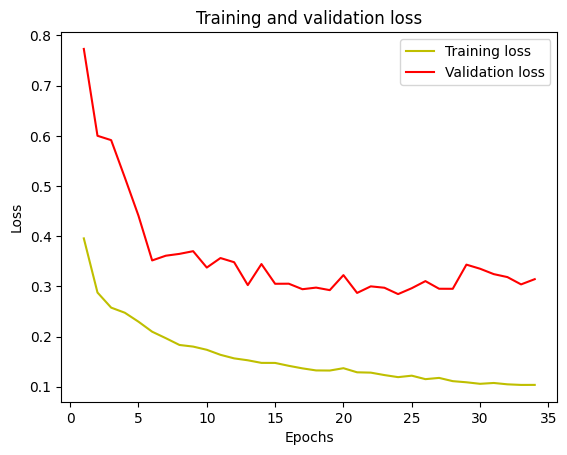

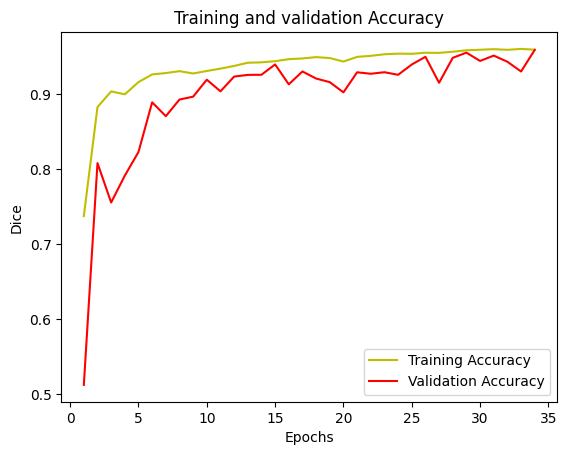

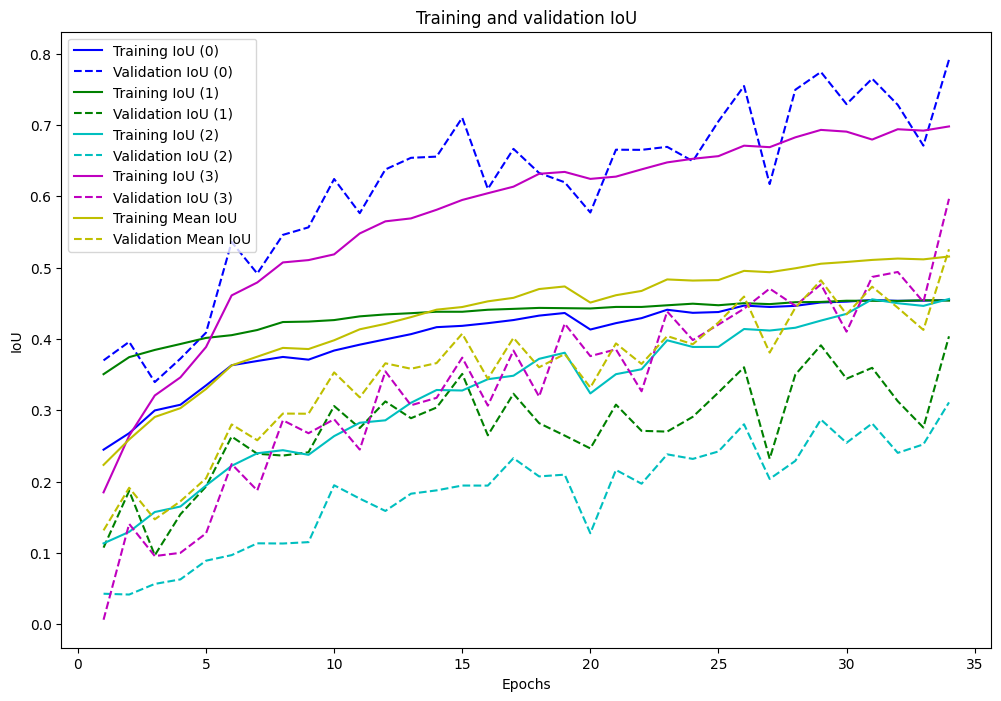

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()



a1 = history.history['one_hot_io_u_4']
a2 = history.history['val_one_hot_io_u_4']
b1 = history.history['one_hot_io_u_5']
b2 = history.history['val_one_hot_io_u_5']
c1 = history.history['one_hot_io_u_6']
c2 = history.history['val_one_hot_io_u_6']
d1 = history.history['one_hot_io_u_7']
d2 = history.history['val_one_hot_io_u_7']
e1 = history.history['one_hot_mean_io_u_1']
e2 = history.history['val_one_hot_mean_io_u_1']

colors = ['b', 'g', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

plt.plot(epochs, a1, color=colors[0], linestyle=line_styles[0], label='Training IoU (0)')
plt.plot(epochs, a2, color=colors[0], linestyle=line_styles[1], label='Validation IoU (0)')
plt.plot(epochs, b1, color=colors[1], linestyle=line_styles[0], label='Training IoU (1)')
plt.plot(epochs, b2, color=colors[1], linestyle=line_styles[1], label='Validation IoU (1)')
plt.plot(epochs, c1, color=colors[2], linestyle=line_styles[0], label='Training IoU (2)')
plt.plot(epochs, c2, color=colors[2], linestyle=line_styles[1], label='Validation IoU (2)')
plt.plot(epochs, d1, color=colors[3], linestyle=line_styles[0], label='Training IoU (3)')
plt.plot(epochs, d2, color=colors[3], linestyle=line_styles[1], label='Validation IoU (3)')
plt.plot(epochs, e1, color=colors[4], linestyle=line_styles[0], label='Training Mean IoU')
plt.plot(epochs, e2, color=colors[4], linestyle=line_styles[1], label='Validation Mean IoU')

plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# ADD DROPOUT

In [ ]:
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
CFC_loss = keras.losses.CategoricalFocalCrossentropy(alpha = [wt0, wt1, wt2, wt3])

In [ ]:
def build_unet_2d(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block_2d(inputs, 32, 0.1)
    s2, p2 = encoder_block_2d(p1, 64, 0.1)
    s3, p3 = encoder_block_2d(p2, 128, 0.2)
    s4, p4 = encoder_block_2d(p3, 256, 0.2)

    b1 = conv_block_2d(p4, 512, 0.3)

    d1 = decoder_block_2d(b1, s4, 256, 0.2)
    d2 = decoder_block_2d(d1, s3, 128, 0.2)
    d3 = decoder_block_2d(d2, s2, 64, 0.1)
    d4 = decoder_block_2d(d3, s1, 32, 0.1)

    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(d4)

    model = Model(inputs, outputs, name='2D_U-Net')
    return model

input_shape = (128, 128, 4)
n_classes = 4

model1 = build_unet_2d(input_shape, n_classes)
model1.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)
model1.summary()

Model: "2D_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 128, 128, 32)   │          1,184 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 128, 128, 32)   │            128 │ conv2d_76[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_72             │ (None, 128, 128, 32)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 128, 128, 32)   │              0 │ activation_72[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 128, 128, 32)   │            128 │ conv2d_77[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_73             │ (None, 128, 128, 32)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 64, 64, 32)     │              0 │ activation_73[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 64, 64, 64)     │            256 │ conv2d_78[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_74             │ (None, 64, 64, 64)     │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_37 (Dropout)      │ (None, 64, 64, 64)     │              0 │ activation_74[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ dropout_37[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_75    │ (None, 64, 64, 64)     │            256 │ conv2d_79[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,772,260 (29.65 MB)

 Trainable params: 7,766,372 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
batch_size = 256

train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

steps_per_epoch = len(train_img_list) // 2
val_steps_per_epoch = len(val_img_list) // 2

######

checkpoint_path = "/content/gdrive/MyDrive/DL_Project/2D_UNet_64.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)

csv = CSVLogger("/content/gdrive/MyDrive/DL_Project/history.csv")

####


In [ ]:

history = model1.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 50,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [checkpoint_callback, early_stopping_callback, csv]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.3657 - loss: 0.6442 - one_hot_io_u_4: 0.2611 - one_hot_io_u_5: 0.2997 - one_hot_io_u_6: 0.0969 - one_hot_io_u_7: 0.1360 - one_hot_mean_io_u_1: 0.1984
Epoch 1: val_loss improved from inf to 0.91361, saving model to /content/gdrive/MyDrive/DL_Project/2D_UNet_64.h5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 128s 573ms/step - accuracy: 0.3670 - loss: 0.6431 - one_hot_io_u_4: 0.2610 - one_hot_io_u_5: 0.3001 - one_hot_io_u_6: 0.0971 - one_hot_io_u_7: 0.1363 - one_hot_mean_io_u_1: 0.1987 - val_accuracy: 0.9509 - val_loss: 0.9136 - val_one_hot_io_u_4: 0.7002 - val_one_hot_io_u_5: 0.0474 - val_one_hot_io_u_6: 4.4040e-05 - val_one_hot_io_u_7: 0.0164 - val_one_hot_mean_io_u_1: 0.1910
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8324 - loss: 0.3335 - one_hot_io_u_4: 0.3589 - one_hot_io_u_5: 0.2615 - one_hot_io_u_6: 0.0889 - one_hot_io_u_7: 0.2102 - one_hot_mean_io_u_1: 0.2299
Epoch 2: val_loss improved from 0.91361 

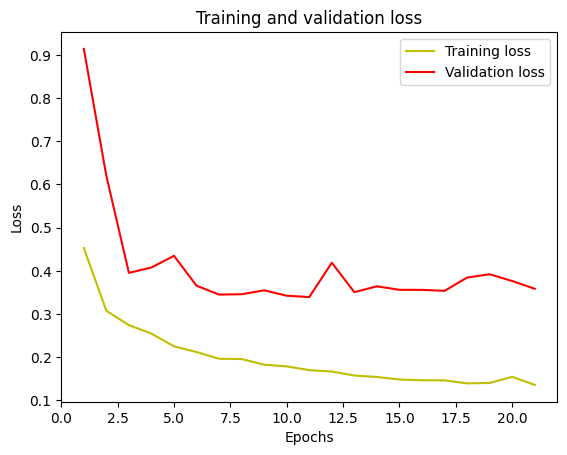

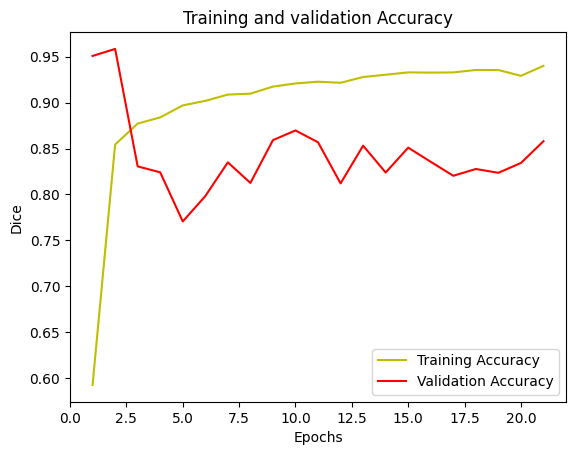

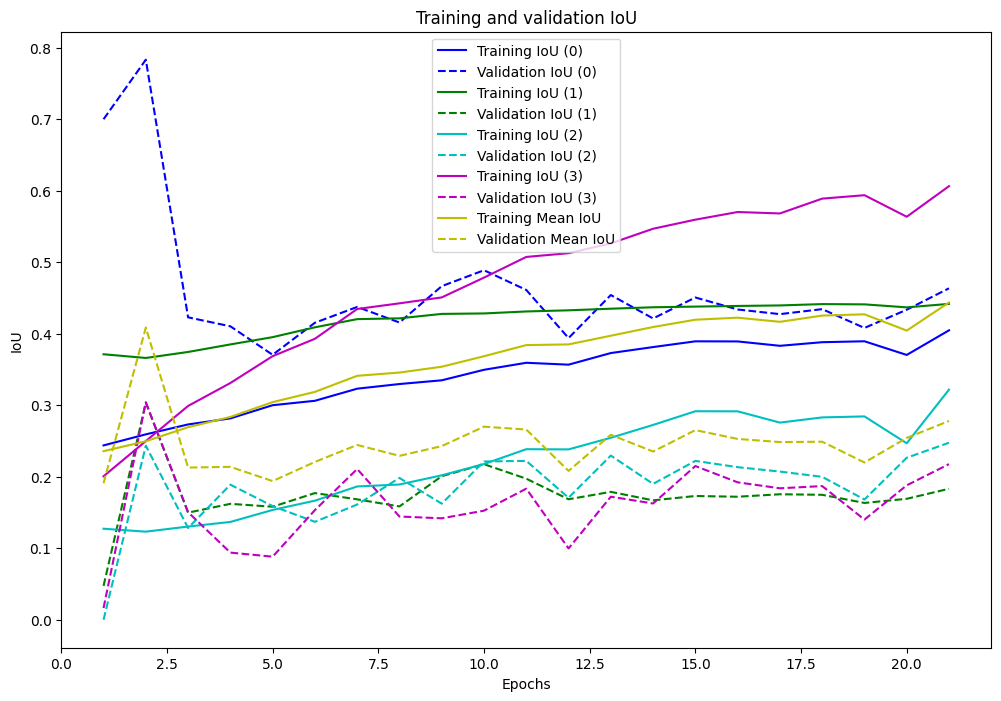

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()



a1 = history.history['one_hot_io_u_4']
a2 = history.history['val_one_hot_io_u_4']
b1 = history.history['one_hot_io_u_5']
b2 = history.history['val_one_hot_io_u_5']
c1 = history.history['one_hot_io_u_6']
c2 = history.history['val_one_hot_io_u_6']
d1 = history.history['one_hot_io_u_7']
d2 = history.history['val_one_hot_io_u_7']
e1 = history.history['one_hot_mean_io_u_1']
e2 = history.history['val_one_hot_mean_io_u_1']

colors = ['b', 'g', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

plt.plot(epochs, a1, color=colors[0], linestyle=line_styles[0], label='Training IoU (0)')
plt.plot(epochs, a2, color=colors[0], linestyle=line_styles[1], label='Validation IoU (0)')
plt.plot(epochs, b1, color=colors[1], linestyle=line_styles[0], label='Training IoU (1)')
plt.plot(epochs, b2, color=colors[1], linestyle=line_styles[1], label='Validation IoU (1)')
plt.plot(epochs, c1, color=colors[2], linestyle=line_styles[0], label='Training IoU (2)')
plt.plot(epochs, c2, color=colors[2], linestyle=line_styles[1], label='Validation IoU (2)')
plt.plot(epochs, d1, color=colors[3], linestyle=line_styles[0], label='Training IoU (3)')
plt.plot(epochs, d2, color=colors[3], linestyle=line_styles[1], label='Validation IoU (3)')
plt.plot(epochs, e1, color=colors[4], linestyle=line_styles[0], label='Training Mean IoU')
plt.plot(epochs, e2, color=colors[4], linestyle=line_styles[1], label='Validation Mean IoU')

plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# ADD L2 REGULARIZATION

In [ ]:
#Define the optimizer
batch_size = 512

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 5e-4,
    decay_steps  = (len(train_img_list) // 4),
    decay_rate = 0.985)

optim = keras.optimizers.Adam(learning_rate = lr_schedule)

In [ ]:
CFC_loss = keras.losses.CategoricalFocalCrossentropy(alpha = [wt0, wt1, wt2, wt3])

IoU_0 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [0])
IoU_1 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [1])
IoU_2 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [2])
IoU_3 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [3])

Mean_IoU = keras.metrics.OneHotMeanIoU(num_classes = 4)

metrics = ["accuracy",  Mean_IoU, IoU_0, IoU_1, IoU_2, IoU_3]

In [ ]:
l2 = tf.keras.regularizers.L2(
    l2 = 0.0001
)

In [ ]:
def conv_block_2d(input, n_filters, dropout_rate):
    x = Conv2D(n_filters, 3, padding='same', kernel_regularizer = l2)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(n_filters, 3, padding='same', kernel_regularizer = l2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block_2d(input, num_filters, dropout_rate):
    x = conv_block_2d(input, num_filters, dropout_rate)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block_2d(input, skip_features, num_filters, dropout_rate):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same', kernel_regularizer = l2)(input)
    x = concatenate([x, skip_features])
    x = conv_block_2d(x, num_filters, dropout_rate)
    return x

In [ ]:
def build_unet_2d(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block_2d(inputs, 32, 0)
    s2, p2 = encoder_block_2d(p1, 64, 0)
    s3, p3 = encoder_block_2d(p2, 128, 0)
    s4, p4 = encoder_block_2d(p3, 256, 0)

    b1 = conv_block_2d(p4, 512, 0)

    d1 = decoder_block_2d(b1, s4, 256, 0)
    d2 = decoder_block_2d(d1, s3, 128, 0)
    d3 = decoder_block_2d(d2, s2, 64, 0)
    d4 = decoder_block_2d(d3, s1, 32, 0)

    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(d4)

    model = Model(inputs, outputs, name='2D_U-Net')
    return model

input_shape = (128, 128, 4)

model2 = build_unet_2d(input_shape, n_classes)
model2.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)
model2.summary()

Model: "2D_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 32)   │          1,184 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 128, 128, 32)   │            128 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 32)   │              0 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 128, 128, 32)   │            128 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 32)     │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 64, 64, 64)     │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 64)     │              0 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 64, 64, 64)     │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,772,260 (29.65 MB)

 Trainable params: 7,766,372 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
batch_size = 512

train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

steps_per_epoch = len(train_img_list) // 4
val_steps_per_epoch = len(val_img_list) // 4

######

checkpoint_path = "/content/gdrive/MyDrive/DL_Project/2D_UNet_32_l2.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)

csv = CSVLogger("/content/gdrive/MyDrive/DL_Project/history_32_l2.csv")

####


In [ ]:
history = model2.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 30,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [checkpoint_callback, early_stopping_callback, csv]
)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3650 - loss: 0.9667 - one_hot_io_u_10: 0.0699 - one_hot_io_u_11: 0.0829 - one_hot_io_u_8: 0.2439 - one_hot_io_u_9: 0.2069 - one_hot_mean_io_u_2: 0.1509
Epoch 1: val_loss improved from inf to 1.06774, saving model to /content/gdrive/MyDrive/DL_Project/2D_UNet_32_l2.h5.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.3672 - loss: 0.9641 - one_hot_io_u_10: 0.0704 - one_hot_io_u_11: 0.0839 - one_hot_io_u_8: 0.2439 - one_hot_io_u_9: 0.2085 - one_hot_mean_io_u_2: 0.1517 - val_accuracy: 0.9368 - val_loss: 1.0677 - val_one_hot_io_u_10: 0.0000e+00 - val_one_hot_io_u_11: 0.0000e+00 - val_one_hot_io_u_8: 0.6411 - val_one_hot_io_u_9: 0.0097 - val_one_hot_mean_io_u_2: 0.1627
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8175 - loss: 0.5252 - one_hot_io_u_10: 0.0929 - one_hot_io_u_11: 0.1440 - one_hot_io_u_8: 0.3488 - one_hot_io_u_9: 0.2326 - one_hot_mean_io_u_2: 0.2046
Epoch 2: val_loss did not improve from 1

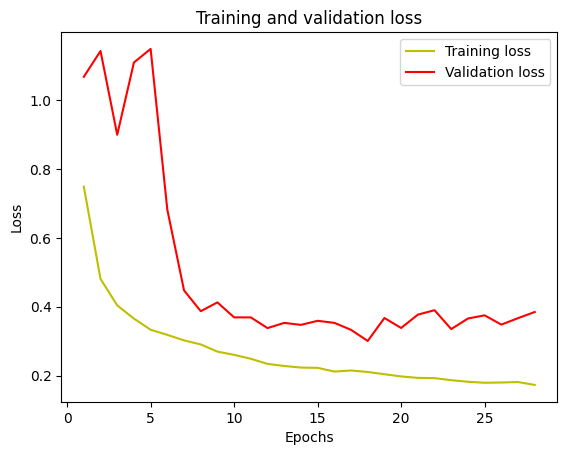

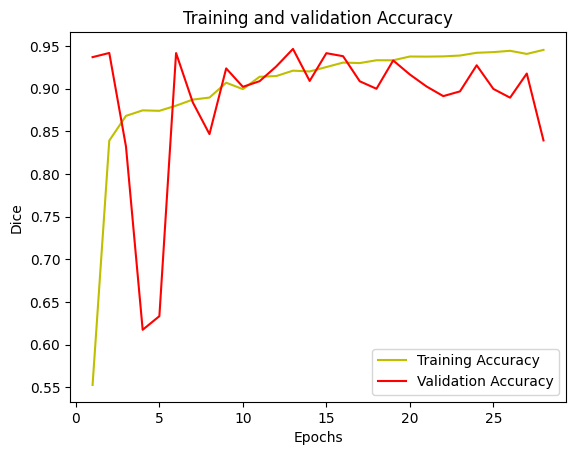

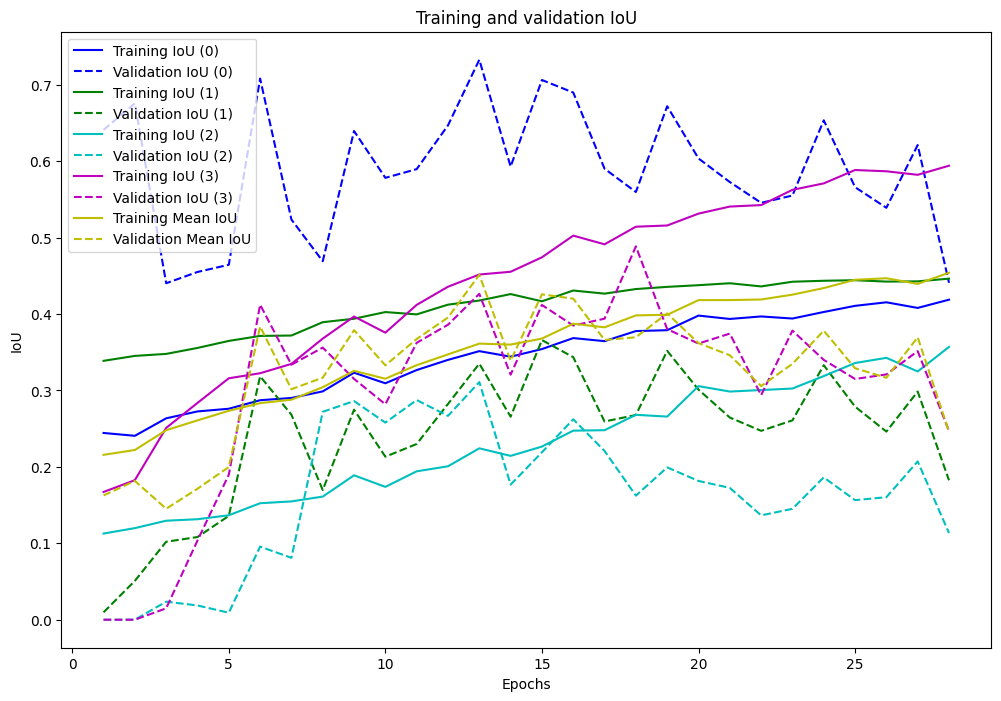

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()



a1 = history.history['one_hot_io_u_8']
a2 = history.history['val_one_hot_io_u_8']
b1 = history.history['one_hot_io_u_9']
b2 = history.history['val_one_hot_io_u_9']
c1 = history.history['one_hot_io_u_10']
c2 = history.history['val_one_hot_io_u_10']
d1 = history.history['one_hot_io_u_11']
d2 = history.history['val_one_hot_io_u_11']
e1 = history.history['one_hot_mean_io_u_2']
e2 = history.history['val_one_hot_mean_io_u_2']

colors = ['b', 'g', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

plt.plot(epochs, a1, color=colors[0], linestyle=line_styles[0], label='Training IoU (0)')
plt.plot(epochs, a2, color=colors[0], linestyle=line_styles[1], label='Validation IoU (0)')
plt.plot(epochs, b1, color=colors[1], linestyle=line_styles[0], label='Training IoU (1)')
plt.plot(epochs, b2, color=colors[1], linestyle=line_styles[1], label='Validation IoU (1)')
plt.plot(epochs, c1, color=colors[2], linestyle=line_styles[0], label='Training IoU (2)')
plt.plot(epochs, c2, color=colors[2], linestyle=line_styles[1], label='Validation IoU (2)')
plt.plot(epochs, d1, color=colors[3], linestyle=line_styles[0], label='Training IoU (3)')
plt.plot(epochs, d2, color=colors[3], linestyle=line_styles[1], label='Validation IoU (3)')
plt.plot(epochs, e1, color=colors[4], linestyle=line_styles[0], label='Training Mean IoU')
plt.plot(epochs, e2, color=colors[4], linestyle=line_styles[1], label='Validation Mean IoU')

plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# ADD 2D SPATIAL DROPOUT (instead of regular dropout)

In [ ]:
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
CFC_loss = keras.losses.CategoricalFocalCrossentropy(alpha = [wt0, wt1, wt2, wt3])
metrics = ["accuracy",  Mean_IoU, IoU_0, IoU_1, IoU_2, IoU_3]

def conv_block_2d(input, n_filters, dropout_rate):
    x = Conv2D(n_filters, 3, padding='same', kernel_regularizer = l2)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout2D(dropout_rate)(x)
    x = Conv2D(n_filters, 3, padding='same', kernel_regularizer = l2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block_2d(input, num_filters, dropout_rate):
    x = conv_block_2d(input, num_filters, dropout_rate)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block_2d(input, skip_features, num_filters, dropout_rate):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same', kernel_regularizer = l2)(input)
    x = concatenate([x, skip_features])
    x = conv_block_2d(x, num_filters, dropout_rate)
    return x

In [ ]:
def build_unet_2d(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block_2d(inputs, 32, 0.1)
    s2, p2 = encoder_block_2d(p1, 64, 0.1)
    s3, p3 = encoder_block_2d(p2, 128, 0.2)
    s4, p4 = encoder_block_2d(p3, 256, 0.2)

    b1 = conv_block_2d(p4, 512, 0.3)

    d1 = decoder_block_2d(b1, s4, 256, 0.2)
    d2 = decoder_block_2d(d1, s3, 128, 0.2)
    d3 = decoder_block_2d(d2, s2, 64, 0.1)
    d4 = decoder_block_2d(d3, s1, 32, 0.1)

    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(d4)

    model = Model(inputs, outputs, name='2D_U-Net')
    return model

input_shape = (128, 128, 4)
n_classes = 4

model3 = build_unet_2d(input_shape, n_classes)
model3.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)
model3.summary()

Model: "2D_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 128, 128, 32)   │          1,184 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 128, 128, 32)   │            128 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 128, 128, 32)   │              0 │ activation_36[0][0]    │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 128, 128, 32)   │            128 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37             │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 64, 64, 32)     │              0 │ activation_37[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 64, 64, 64)     │            256 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_1       │ (None, 64, 64, 64)     │              0 │ activation_38[0][0]    │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ spatial_dropout2d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 7,772,260 (29.65 MB)

 Trainable params: 7,766,372 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
batch_size = 512

train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

steps_per_epoch = len(train_img_list) // 4
val_steps_per_epoch = len(val_img_list) // 4

######

# Callback per salvare il miglior modello basato sulla loss di validazione
checkpoint_path = "/content/gdrive/MyDrive/DL_Project/2D_UNet_32_l2*drop.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',    # Monitorare la loss di validazione
    patience = 10,           # Numero di epoche con nessun miglioramento dopo le quali l'addestramento verrà fermato
    restore_best_weights = True # Ripristina i pesi del miglior modello visto durante l'addestramento
)

csv = CSVLogger("/content/gdrive/MyDrive/DL_Project/history_32_l2*drop.csv")

####

In [ ]:
history = model3.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 30,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [checkpoint_callback, early_stopping_callback, csv]
)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.5545 - loss: 0.9076 - one_hot_io_u_10: 0.0934 - one_hot_io_u_11: 0.1194 - one_hot_io_u_8: 0.2505 - one_hot_io_u_9: 0.2637 - one_hot_mean_io_u_2: 0.1818
Epoch 1: val_loss improved from inf to 0.98163, saving model to /content/gdrive/MyDrive/DL_Project/2D_UNet_32_l2*drop.h5.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.5558 - loss: 0.9054 - one_hot_io_u_10: 0.0938 - one_hot_io_u_11: 0.1202 - one_hot_io_u_8: 0.2504 - one_hot_io_u_9: 0.2647 - one_hot_mean_io_u_2: 0.1823 - val_accuracy: 0.9503 - val_loss: 0.9816 - val_one_hot_io_u_10: 9.3930e-06 - val_one_hot_io_u_11: 6.3555e-06 - val_one_hot_io_u_8: 0.6939 - val_one_hot_io_u_9: 0.0140 - val_one_hot_mean_io_u_2: 0.1770
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.8141 - loss: 0.5129 - one_hot_io_u_10: 0.0900 - one_hot_io_u_11: 0.1762 - one_hot_io_u_8: 0.3595 - one_hot_io_u_9: 0.2249 - one_hot_mean_io_u_2: 0.2127
Epoch 2: val_loss did not imp

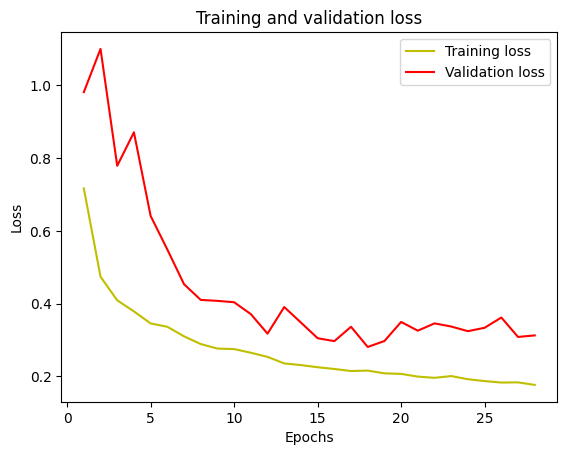

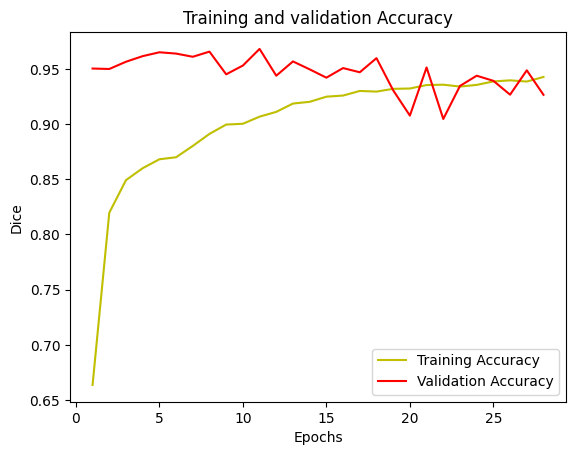

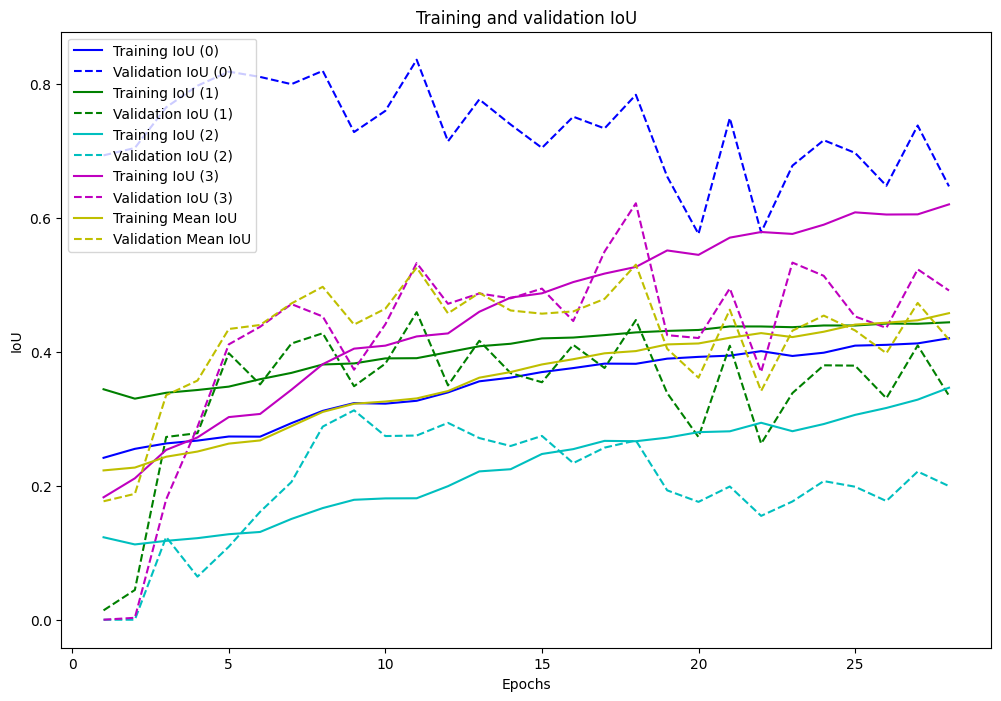

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()



a1 = history.history['one_hot_io_u_8']
a2 = history.history['val_one_hot_io_u_8']
b1 = history.history['one_hot_io_u_9']
b2 = history.history['val_one_hot_io_u_9']
c1 = history.history['one_hot_io_u_10']
c2 = history.history['val_one_hot_io_u_10']
d1 = history.history['one_hot_io_u_11']
d2 = history.history['val_one_hot_io_u_11']
e1 = history.history['one_hot_mean_io_u_2']
e2 = history.history['val_one_hot_mean_io_u_2']

colors = ['b', 'g', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

plt.plot(epochs, a1, color=colors[0], linestyle=line_styles[0], label='Training IoU (0)')
plt.plot(epochs, a2, color=colors[0], linestyle=line_styles[1], label='Validation IoU (0)')
plt.plot(epochs, b1, color=colors[1], linestyle=line_styles[0], label='Training IoU (1)')
plt.plot(epochs, b2, color=colors[1], linestyle=line_styles[1], label='Validation IoU (1)')
plt.plot(epochs, c1, color=colors[2], linestyle=line_styles[0], label='Training IoU (2)')
plt.plot(epochs, c2, color=colors[2], linestyle=line_styles[1], label='Validation IoU (2)')
plt.plot(epochs, d1, color=colors[3], linestyle=line_styles[0], label='Training IoU (3)')
plt.plot(epochs, d2, color=colors[3], linestyle=line_styles[1], label='Validation IoU (3)')
plt.plot(epochs, e1, color=colors[4], linestyle=line_styles[0], label='Training Mean IoU')
plt.plot(epochs, e2, color=colors[4], linestyle=line_styles[1], label='Validation Mean IoU')

plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()